In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import log_loss
import time

SPLITDATE = "2018-01-01"
windowLen = 10

df = pd.read_csv("daily_changes.csv", sep=",")[["date", "BTC", "ETH", "DOGE", "LTC", "XRP"]]

trainingSet, testSet = df[df["date"] < SPLITDATE], df[df["date"] >= SPLITDATE]
trainingSet = trainingSet.drop(["date"], 1)
testSet = testSet.drop(["date"], 1)

trainingLabels = trainingSet.copy()[1 + windowLen:]
testLabels = testSet.copy()[1 + windowLen:]

trainingSet = trainingSet[:trainingSet.shape[0] - 1]
testSet = testSet[:testSet.shape[0] - 1]

trainingLabels = trainingLabels.assign(max=df.max(axis=1))
testLabels = testLabels.assign(max=df.max(axis=1))

columns = list(filter(lambda x: x not in ("max", "date"), df.columns))
for column in columns:
    trainingLabels.loc[trainingLabels[column] != trainingLabels["max"], column] = 0
    trainingLabels.loc[trainingLabels[column] == trainingLabels["max"], column] = 1
    testLabels.loc[testLabels[column] != testLabels["max"], column] = 0
    testLabels.loc[testLabels[column] == testLabels["max"], column] = 1

trainingLabels = trainingLabels.drop(["max"], 1).applymap(lambda x: int(x))
testLabels = testLabels.drop(["max"], 1).applymap(lambda x: int(x))

trainingInputs = []
for i in range(len(trainingSet) - windowLen):
    tmpSet = trainingSet[i:(i + windowLen)].copy()

    for col in list(tmpSet.columns):
        tmpSet[col] = tmpSet[col]/tmpSet[col].iloc[0] - 1

    trainingInputs.append(tmpSet)

trainingInputs = [np.array(trainingInput) for trainingInput in trainingInputs]
trainingInputs = np.array(trainingInputs)

testInputs = []
for i in range(len(testSet) - windowLen):
    tmpSet = testSet[i:(i + windowLen)].copy()

    for col in list(tmpSet.columns):
        tmpSet[col] = tmpSet[col]/tmpSet[col].iloc[0] - 1

    testInputs.append(tmpSet)

testInputs = [np.array(testInput) for testInput in testInputs]
testInputs = np.array(testInputs)

In [243]:
# Model Building

model = Sequential()

model.add(LSTM(
    units=512,
    input_shape=(trainingInputs.shape[1], trainingInputs.shape[2])
))
model.add(Dropout(0.2))

model.add(Dense(units=trainingLabels.shape[1], activation="softmax"))

model.summary()

start = time.time()
model.compile(
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)
print("compilation time : ", time.time() - start)

model.fit(
    trainingInputs,
    trainingLabels,
    batch_size=50,
    nb_epoch=10,
    validation_split=0.05
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 512)               1060864   
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 2565      
Total params: 1,063,429
Trainable params: 1,063,429
Non-trainable params: 0
_________________________________________________________________
compilation time :  0.031411170959472656


/Users/KenLu/anaconda/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 336 samples, validate on 18 samples
Epoch 1/10
336/336 [==============================] - 4s 11ms/step - loss: 1.6126 - acc: 0.1786 - val_loss: 1.6081 - val_acc: 0.1111
Epoch 2/10
336/336 [==============================] - 0s 973us/step - loss: 1.6094 - acc: 0.2173 - val_loss: 1.6007 - val_acc: 0.1667
Epoch 3/10
336/336 [==============================] - 0s 939us/step - loss: 1.6019 - acc: 0.2321 - val_loss: 1.5967 - val_acc: 0.1111
Epoch 4/10
336/336 [==============================] - 0s 957us/step - loss: 1.5982 - acc: 0.2530 - val_loss: 1.6107 - val_acc: 0.1667
Epoch 5/10
336/336 [==============================] - 0s 955us/step - loss: 1.5978 - acc: 0.2530 - val_loss: 1.5969 - val_acc: 0.2222
Epoch 6/10
336/336 [==============================] - 0s 954us/step - loss: 1.5988 - acc: 0.2351 - val_loss: 1.6107 - val_acc: 0.2778
Epoch 7/10
336/336 [==============================] - 0s 970us/step - loss: 1.5936 - acc: 0.2351 - val_loss: 1.6051 - val_acc: 0.2778
Epoch 8/10
336/336

In [247]:
# Accuracy

topK = 1

training_predicted = model.predict(trainingInputs)
training_predicted_classes = np.fliplr(training_predicted.argsort(axis=1))[:,:topK]
training_actual_classes = np.argmax(np.array(trainingLabels), axis=1)

training_predictions = []
for i,x in enumerate(training_actual_classes):
    training_predictions.append(x in training_predicted_classes[i])

print("Training Accuracy: ", training_predictions.count(True)/len(training_predictions))

test_predicted = model.predict(testInputs)
test_predicted_classes = np.fliplr(test_predicted.argsort(axis=1))[:,:topK]
test_actual_classes = np.argmax(np.array(testLabels), axis=1)

test_predictions = []
for i,x in enumerate(test_actual_classes):
    test_predictions.append(x in test_predicted_classes[i])

print("Test Accuracy: ", test_predictions.count(True)/len(test_predictions))

Training Accuracy:  0.268361581920904
Test Accuracy:  0.16393442622950818


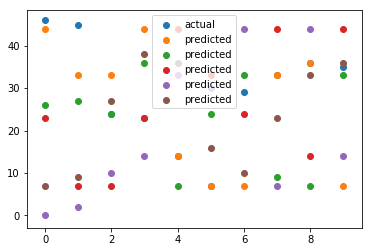

The Cross Entropy Loss is: 2.635007719009441


In [182]:
# Ploting

plt.scatter(x=range(training_actual_classes[:10].shape[0]), y=training_actual_classes[:10], label="actual")
plt.scatter(x=range(training_predicted_classes[:10].shape[0]), y=[c[0] for c in training_predicted_classes[:10, 0:]], label="predicted")
plt.scatter(x=range(training_predicted_classes[:10].shape[0]), y=[c[0] for c in training_predicted_classes[:10, 1:]], label="predicted")
plt.scatter(x=range(training_predicted_classes[:10].shape[0]), y=[c[0] for c in training_predicted_classes[:10, 2:]], label="predicted")
plt.scatter(x=range(training_predicted_classes[:10].shape[0]), y=[c[0] for c in training_predicted_classes[:10, 3:]], label="predicted")
plt.scatter(x=range(training_predicted_classes[:10].shape[0]), y=[c[0] for c in training_predicted_classes[:10, 4:]], label="predicted")
plt.legend()
plt.show()
CEL = log_loss(trainingLabels, model.predict(trainingInputs))
print('The Cross Entropy Loss is: {}'.format(CEL))